Click [here](https://colab.research.google.com/drive/1QODTEfF5YTcD4tVZwDaNdGdu7Dl9Axdo#scrollTo=81D_7JMXqIjc&line=1&uniqifier=1) to obtain the data.

Below step is used to unzip the data 

In [1]:
from zipfile import ZipFile 
file_name='<path>/<name>.zip'
with ZipFile(file_name,'r') as zipObj:zipObj.extractall()
print('done')

done


Importing the essential libraries

In [4]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.applications.vgg16 import VGG16,preprocess_input 
from keras.applications import InceptionV3,inception_v3
from keras.applications import ResNet50,resnet50 
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from sklearn import metrics
init_notebook_mode(connected=True)
RANDOM_SEED = 123



Croping the images and remove the noise.

In [8]:


def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)



Function for loading the data and resize the data

In [9]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

Calling the function to load the training and testing data

In [10]:
from keras.models import load_model
TRAIN_DIR = 'Training/'
TEST_DIR = 'Testing/'

IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
#X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 4/4 [00:10<00:00,  2.54s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

  0%|          | 0/4 [00:00<?, ?it/s]

2870 images loaded from Training/ directory.


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

394 images loaded from Testing/ directory.


Visualization of the number of images in the training data in each class

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



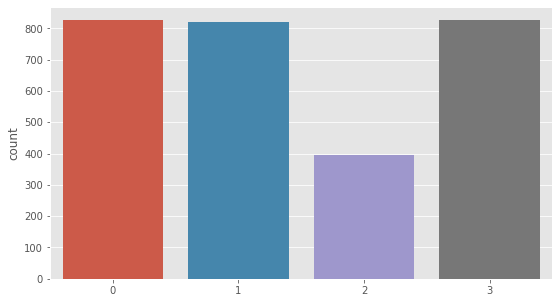

In [ ]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(9,5))
sns.countplot(y_train)
plt.show()

Visualization of the test data in each class

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



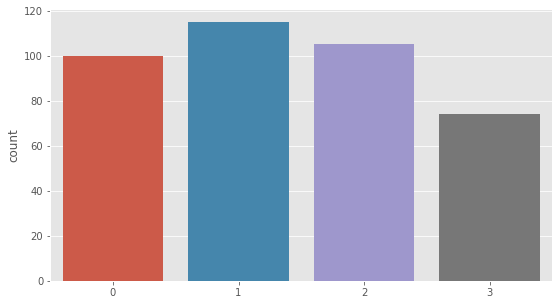

In [ ]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(9,5))
sns.countplot(y_test)
plt.show()

Save the edited images in the directories

In [11]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'glioma/'+str(i)+'.jpg', img)
        elif imclass==1:
            cv2.imwrite(folder_name+'meningioma/'+str(i)+'.jpg', img)
        elif imclass==2:
            cv2.imwrite(folder_name+'no_tumor/'+str(i)+'.jpg', img)
        elif imclass==3:
            cv2.imwrite(folder_name+'pituitary/'+str(i)+'.jpg', img)
        i += 1

In [12]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
#X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [13]:

# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP  TRAIN_CROP/glioma TRAIN_CROP/meningioma TRAIN_CROP/no_tumor TRAIN_CROP/pituitary TEST_CROP/glioma TEST_CROP/meningioma TEST_CROP/no_tumor TEST_CROP/pituitary

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')



## Data augmentation

In [ ]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = datagen.flow_from_directory(
    directory= "TRAIN_CROP/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=8,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

valid_datagen = ImageDataGenerator(rescale = 1./255)

valid_generator = valid_datagen.flow_from_directory(
    directory= "TEST_CROP/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=8,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


## Modeling

In [ ]:
#using the testing data as the validation data where lr=.00001
from keras.optimizers import *
import keras
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

inception = keras.applications.InceptionV3(include_top = False, weights = 'imagenet', input_tensor = None, input_shape = (224,224,3))
x = inception.output
#x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(4,activation = 'softmax',name = 'softmax')(x)
final_model = keras.Model(inputs = inception.input, outputs = output_layer)
opt = keras.optimizers.Adam(lr = 0.00001)
final_model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])


from keras.callbacks import *

es = EarlyStopping(monitor = 'val_loss',verbose = 1,mode='min')
plat = ReduceLROnPlateau(monitor = 'val_loss',verbose=1,factor=0.1,min_lr = 0.00001,patience=5)
Checkpoint= ModelCheckpoint("Model_drop3.h5", monitor='val_loss', verbose=1, save_best_only=True,
       save_weights_only=True,mode='min')


train_history2 = final_model.fit(
            train_generator,
            validation_data = valid_generator,
            callbacks=[plat,Checkpoint],
            epochs=30,
            verbose=1
            )

Epoch 1/30
359/359 [==============================] - 44s 109ms/step - loss: 1.5900 - accuracy: 0.3433 - val_loss: 1.3968 - val_accuracy: 0.4213

Epoch 00001: val_loss improved from inf to 1.39680, saving model to Model_drop3.h5
Epoch 2/30
359/359 [==============================] - 38s 105ms/step - loss: 1.1419 - accuracy: 0.5399 - val_loss: 1.1056 - val_accuracy: 0.5635

Epoch 00002: val_loss improved from 1.39680 to 1.10560, saving model to Model_drop3.h5
Epoch 3/30
359/359 [==============================] - 38s 106ms/step - loss: 0.8651 - accuracy: 0.6538 - val_loss: 1.1071 - val_accuracy: 0.5787

Epoch 00003: val_loss did not improve from 1.10560
Epoch 4/30
359/359 [==============================] - 38s 106ms/step - loss: 0.7184 - accuracy: 0.7142 - val_loss: 1.1049 - val_accuracy: 0.5660

Epoch 00004: val_loss improved from 1.10560 to 1.10495, saving model to Model_drop3.h5
Epoch 5/30
359/359 [==============================] - 38s 106ms/step - loss: 0.6737 - accuracy: 0.7387 - val

Loss plot 

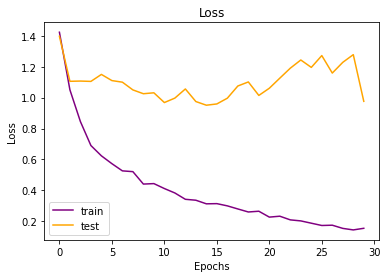

In [ ]:
train_history2
plt.plot(train_history2.history["loss"],c = "purple")
plt.plot(train_history2.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

Accuracy plot

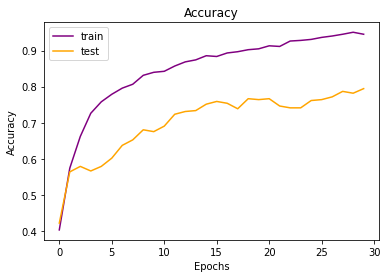

In [ ]:
plt.plot(train_history2.history["accuracy"],c = "purple")
plt.plot(train_history2.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

To get the prediction of the model

In [28]:
#Feeding Testing Data to X_train and y_train

test_dir = "/content/Testing"
test_glioma = "/content/Testing/glioma_tumor"
test_meningioma = "/content/Testing/meningioma_tumor"
test_no_tumour = "/content/Testing/no_tumor"
test_pituitary = "/content/Testing/pituitary_tumor"

X_test = []
y_test = []

for i in tqdm(os.listdir(test_glioma)):
    path = os.path.join(test_glioma,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    X_test.append(img)
    y_test.append('Glioma')
    
for i in tqdm(os.listdir(test_meningioma)):
    path = os.path.join(test_meningioma,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    X_test.append(img)
    y_test.append('Meningioma')
    

for i in tqdm(os.listdir(test_no_tumour)):
    path = os.path.join(test_no_tumour,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    X_test.append(img)
    y_test.append('No_Tumour') 
    
for i in tqdm(os.listdir(test_pituitary)):
    path = os.path.join(test_pituitary,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    X_test.append(img)
    y_test.append('Pituitary')

100%|██████████| 74/74 [00:00<00:00, 121.52it/s]


In [29]:
X_test = np.array(X_test)
y_test = np.array(y_test)
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

X_test shape: (394, 224, 224, 3)
y_test shape: (394,)


In [30]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
y_test = le.fit_transform(y_test)

In [31]:
X_test = X_test/255.0 

In [ ]:
predictions=final_model.predict(X_test)
import numpy as np
y_pred = np.argmax(predictions,axis=1)

In [ ]:
metrics.accuracy_score(y_test,y_pred)

0.8147208121827412

Print out the images to show the actual and predicted class of the image.

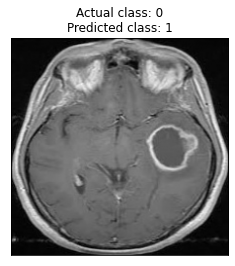

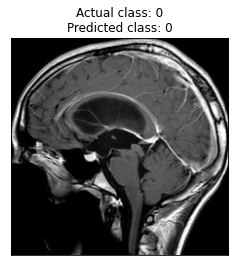

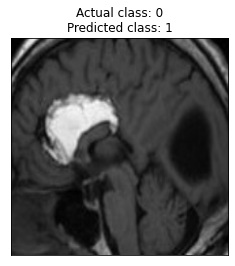

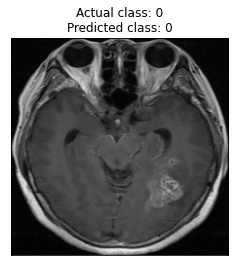

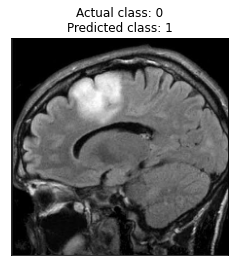

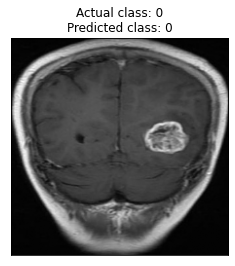

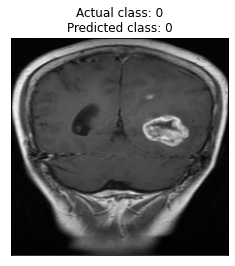

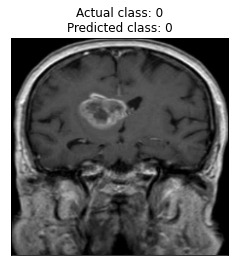

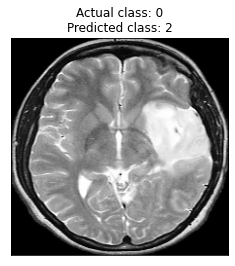

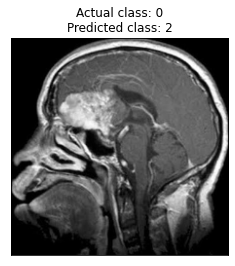

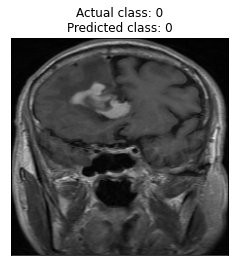

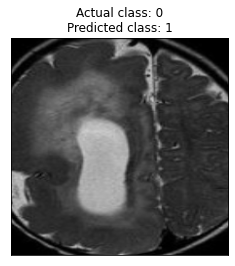

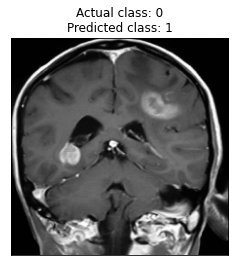

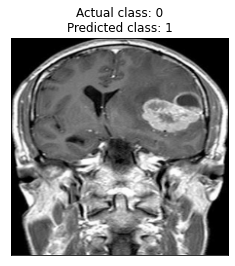

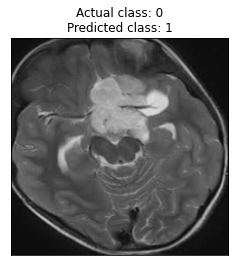

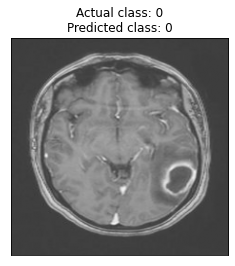

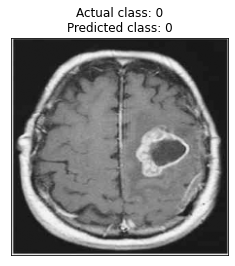

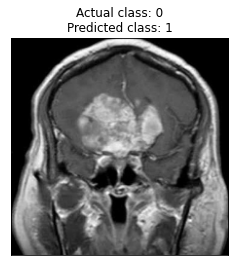

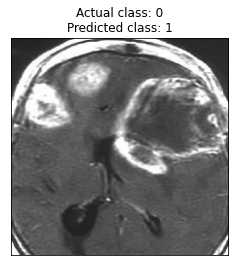

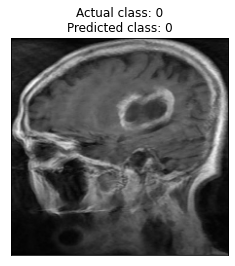

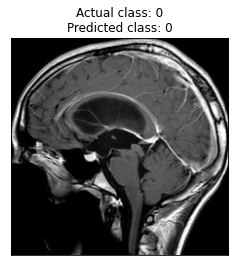

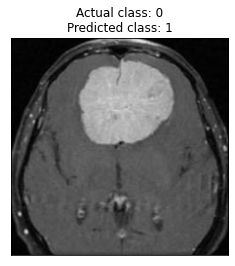

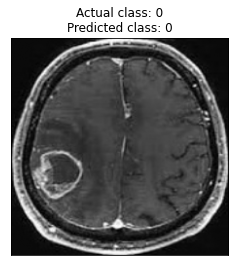

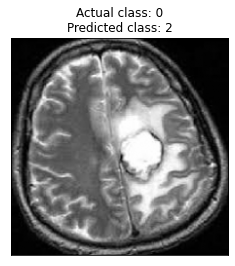

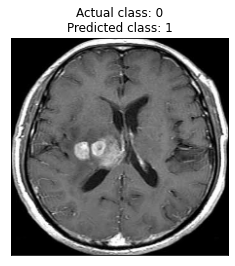

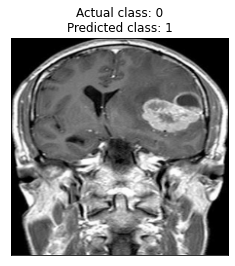

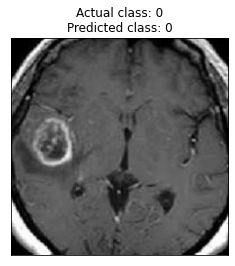

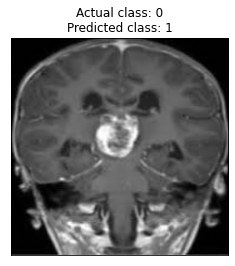

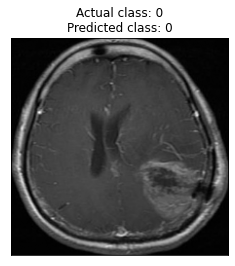

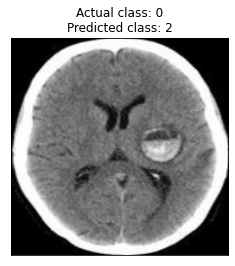

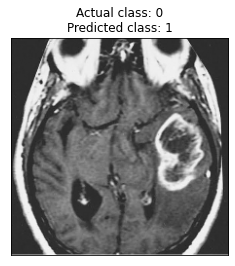

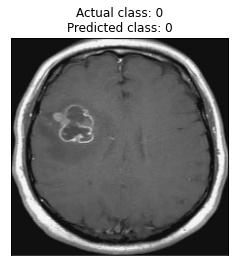

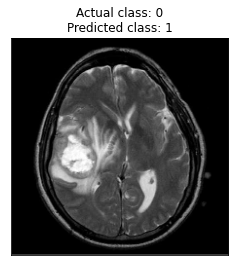

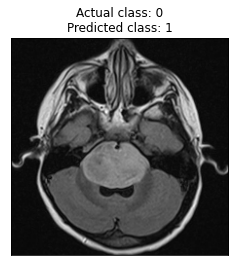

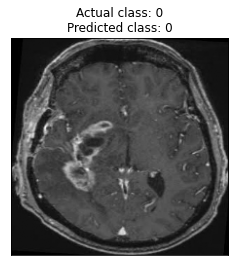

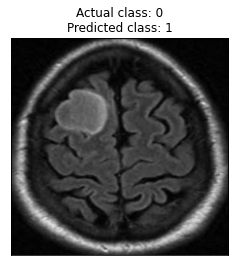

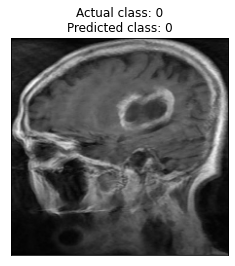

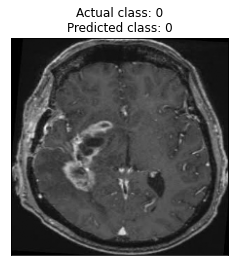

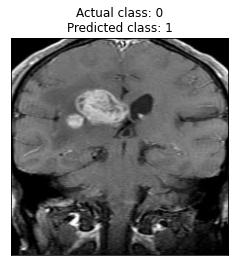

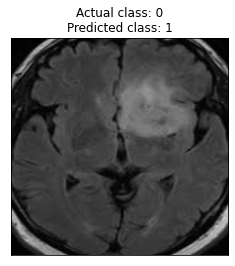

In [ ]:
for i in range(40):
    plt.figure()
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {y_pred[i]}')
    plt.show()

Only the weights of the model was saved. I want to save the entire model for deploying the model.

In [24]:
import keras
inception = keras.applications.InceptionV3(include_top = False, weights = 'imagenet', input_tensor = None, input_shape = (224,224,3))
x = inception.output
#x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(4,activation = 'softmax',name = 'softmax')(x)
final_model = keras.Model(inputs = inception.input, outputs = output_layer)

#loading the weights to save the model
final_model.load_weights('/content/Model_drop3_81.h5')


In [25]:
#saving the whole model
final_model.save('my_model.hdf5')

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [32]:
predictions=final_model.predict(X_test)
import numpy as np
y_pred = np.argmax(predictions,axis=1)

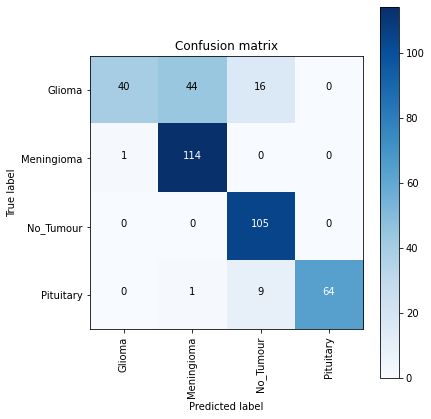

In [34]:
labels=['Glioma','Meningioma','No_Tumour','Pituitary']
confusion_mtx = confusion_matrix(y_test, y_pred) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)